<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_11/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [34]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder
!pip install grad-cam

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'dl_hub' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports:

In [35]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_11")
sys.path.append("dl_hub")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.main import setup_model,build_model
from dl_hub.utils.utils import model_summary, get_incorrect_predictions, generate_grad_cam_visualizations
from dl_hub.utils.vis_utils import show_incorrect_predictions, plot_statistics, plot_losses, plot_accuracy, plot_lr_values, show_incorrect_predictions, plot_image_grid, preview_images, print_train_log

Define Albumentations image augmentations. We use RandomCrop, HorizontalFlip, and cutout

In [36]:
train_transforms = A.Compose(
    [
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16,
                                                max_width=16, min_holes = 1,
                                                min_height=16, min_width=16,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([

    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define Optimizer and Scheduler

In [37]:
optimizer_type = 'SGD'
optimizer_params = {
    'weight_decay': 5e-4,
    'lr': 0.01,
    'momentum': 0.9
}
scheduler_type = 'ReduceLrOnPlateau'
scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 4,
    'threshold': 0.1
}
loss_func = nn.CrossEntropyLoss()

Define Parameters

In [38]:
params = {}
params['model_type'] = 'RESNET18'
params['dataset_name'] = 'CIFAR10'
params['batch_size'] = 512
params['train_transforms'] = train_transforms
params['test_transforms'] = test_transforms
params['num_workers'] = 2
params['num_epochs'] = 20
params['optimizer_type'] = optimizer_type
params['optimizer_params'] = optimizer_params
params['scheduler_type'] = scheduler_type
params['scheduler_params'] = scheduler_params
params['loss_func'] = loss_func

Set Up Model

In [39]:
device, train_loader, test_loader, class_names, model, optimizer, scheduler = setup_model(params)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

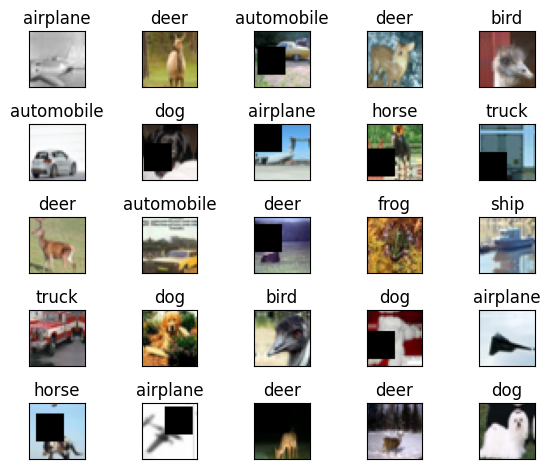

In [40]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Model Summary

In [41]:
model_summary(model, input_size = (3,32,32))

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
ResNet                                   --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
├─BatchNorm2d: 1-2                       --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
├─Sequential: 1-3                        --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─BasicBlock: 2-1                   --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [3, 3]                    [1, 64, 32, 32]           [1, 

Build the Model

In [42]:
train_losses, test_losses, train_acc, test_acc, lr_values = build_model(model, device, train_loader, test_loader, optimizer, scheduler, params)

epoch: 1	 learning rate: 0.01


loss=1.398420810699463 batch_id=97 Accuracy = 38.03: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.0027, Accuracy: 5058/10000 (50.58%)

epoch: 2	 learning rate: 0.01


loss=1.1065130233764648 batch_id=97 Accuracy = 54.37: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]



Test set: Average loss: 0.0023, Accuracy: 5928/10000 (59.28%)

epoch: 3	 learning rate: 0.01


loss=0.975060224533081 batch_id=97 Accuracy = 61.72: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0022, Accuracy: 6260/10000 (62.60%)

epoch: 4	 learning rate: 0.01


loss=0.8076809644699097 batch_id=97 Accuracy = 67.08: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0018, Accuracy: 6913/10000 (69.13%)

epoch: 5	 learning rate: 0.01


loss=0.7410128712654114 batch_id=97 Accuracy = 71.11: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0020, Accuracy: 6804/10000 (68.04%)

epoch: 6	 learning rate: 0.01


loss=0.730962872505188 batch_id=97 Accuracy = 73.78: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0017, Accuracy: 7185/10000 (71.85%)

epoch: 7	 learning rate: 0.01


loss=0.5687960982322693 batch_id=97 Accuracy = 75.94: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0012, Accuracy: 7876/10000 (78.76%)

epoch: 8	 learning rate: 0.01


loss=0.5356851816177368 batch_id=97 Accuracy = 77.84: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0011, Accuracy: 8087/10000 (80.87%)

epoch: 9	 learning rate: 0.01


loss=0.6260489225387573 batch_id=97 Accuracy = 79.01: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0012, Accuracy: 8012/10000 (80.12%)

epoch: 10	 learning rate: 0.01


loss=0.5919869542121887 batch_id=97 Accuracy = 80.35: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0011, Accuracy: 8249/10000 (82.49%)

epoch: 11	 learning rate: 0.01


loss=0.5462886095046997 batch_id=97 Accuracy = 81.48: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0015, Accuracy: 7698/10000 (76.98%)

epoch: 12	 learning rate: 0.01


loss=0.5118177533149719 batch_id=97 Accuracy = 82.75: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0012, Accuracy: 8119/10000 (81.19%)

epoch: 13	 learning rate: 0.01


loss=0.5214524865150452 batch_id=97 Accuracy = 83.61: 100%|██████████| 98/98 [00:41<00:00,  2.33it/s]



Test set: Average loss: 0.0010, Accuracy: 8273/10000 (82.73%)

epoch: 14	 learning rate: 0.01


loss=0.49139830470085144 batch_id=97 Accuracy = 84.21: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0012, Accuracy: 8036/10000 (80.36%)

epoch: 15	 learning rate: 0.01


loss=0.37223678827285767 batch_id=97 Accuracy = 84.70: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]



Test set: Average loss: 0.0010, Accuracy: 8435/10000 (84.35%)

Epoch 00015: reducing learning rate of group 0 to 1.0000e-03.
epoch: 16	 learning rate: 0.001


loss=0.3040849268436432 batch_id=97 Accuracy = 87.88: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0007, Accuracy: 8910/10000 (89.10%)

epoch: 17	 learning rate: 0.001


loss=0.3451991677284241 batch_id=97 Accuracy = 89.20: 100%|██████████| 98/98 [00:41<00:00,  2.33it/s]



Test set: Average loss: 0.0007, Accuracy: 8918/10000 (89.18%)

epoch: 18	 learning rate: 0.001


loss=0.3051891028881073 batch_id=97 Accuracy = 89.28: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0007, Accuracy: 8941/10000 (89.41%)

epoch: 19	 learning rate: 0.001


loss=0.2751637399196625 batch_id=97 Accuracy = 89.62: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0007, Accuracy: 8915/10000 (89.15%)

epoch: 20	 learning rate: 0.001


loss=0.23199757933616638 batch_id=97 Accuracy = 89.93: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0007, Accuracy: 8925/10000 (89.25%)



Get Incorrect Predictions

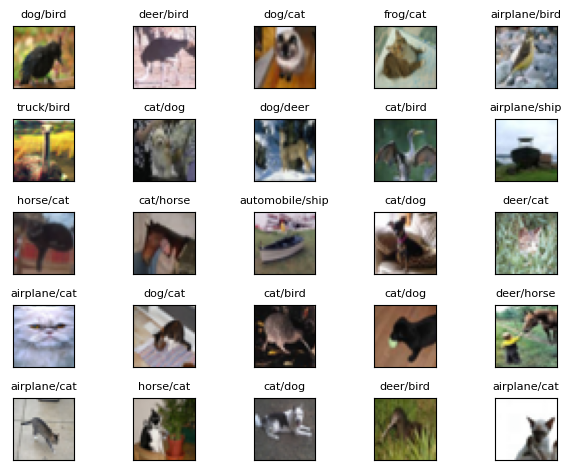

In [43]:
num_rows = 5
num_cols = 5
incorrect_predictions = get_incorrect_predictions(model, test_loader, device)
show_incorrect_predictions(incorrect_predictions, class_names, num_rows, num_cols)

Grad Cam Visualization

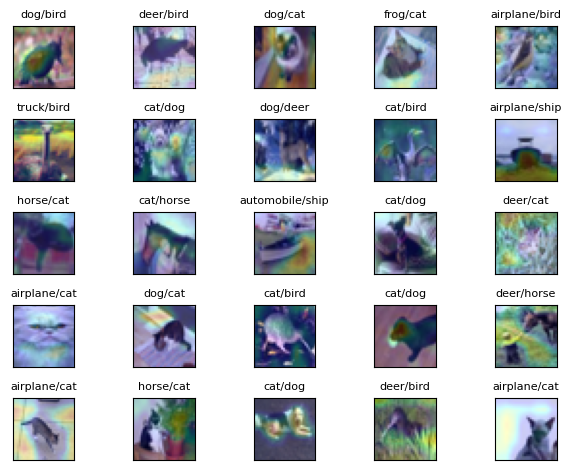

In [50]:
target_layers = [model.layer3[-1]]
num_rows = 5
num_cols = 5
num_images_to_compute = num_rows*num_cols
grad_cam_map_list, prediction_list, ground_truth_list = generate_grad_cam_visualizations(model, target_layers, incorrect_predictions, class_names, num_images_to_compute=num_images_to_compute, image_weight=0.8)
plot_image_grid(grad_cam_map_list, prediction_list, ground_truth_list, num_rows, num_cols)

Plot LR values

Plot results for Batch Norm experiment

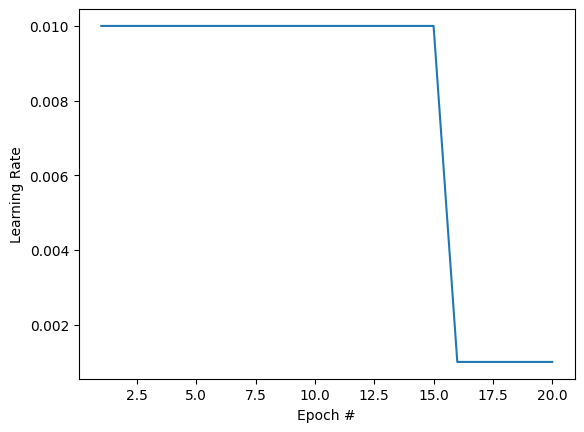

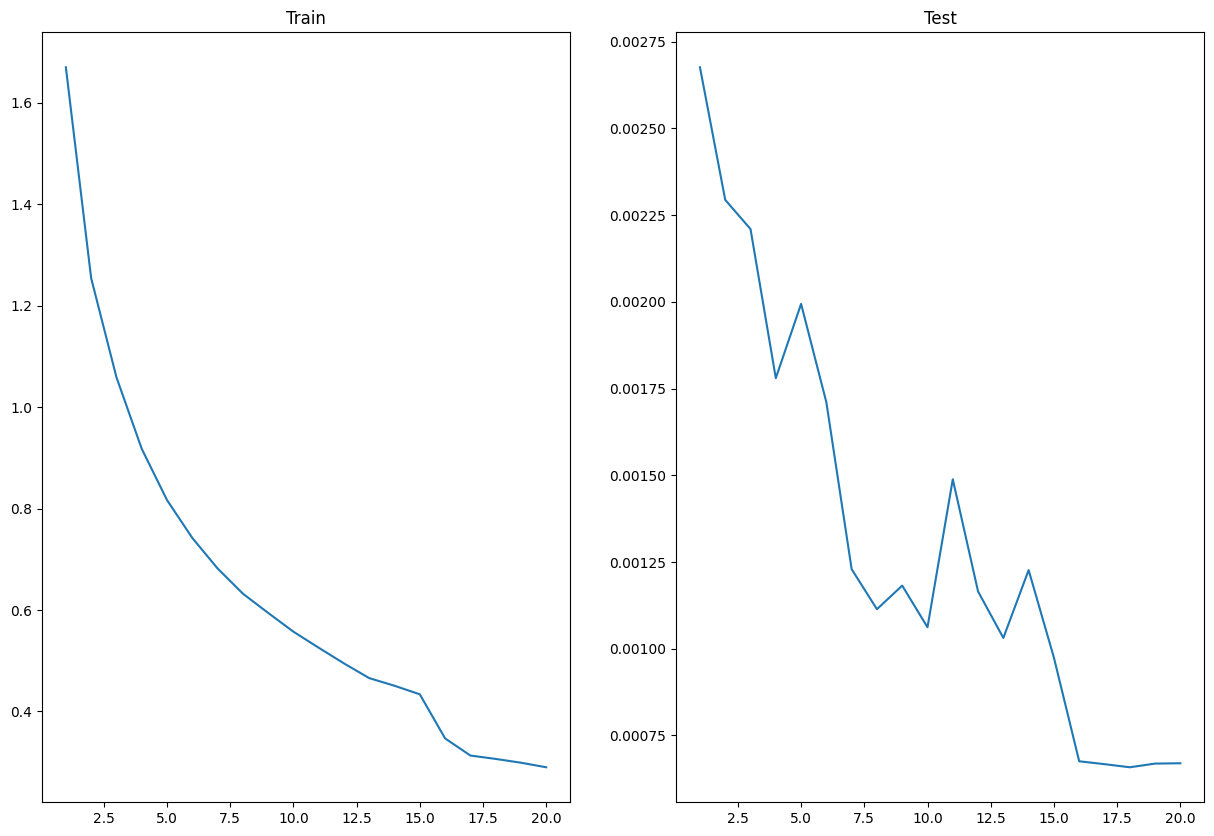

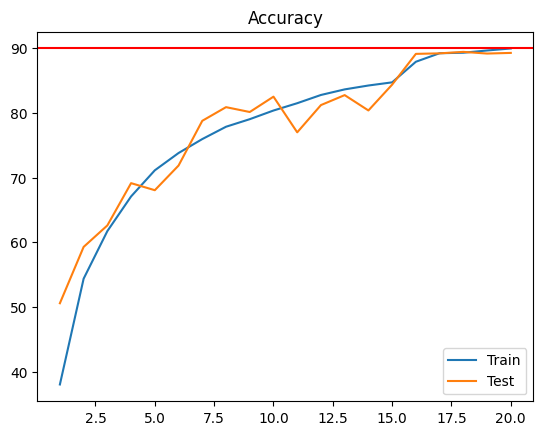

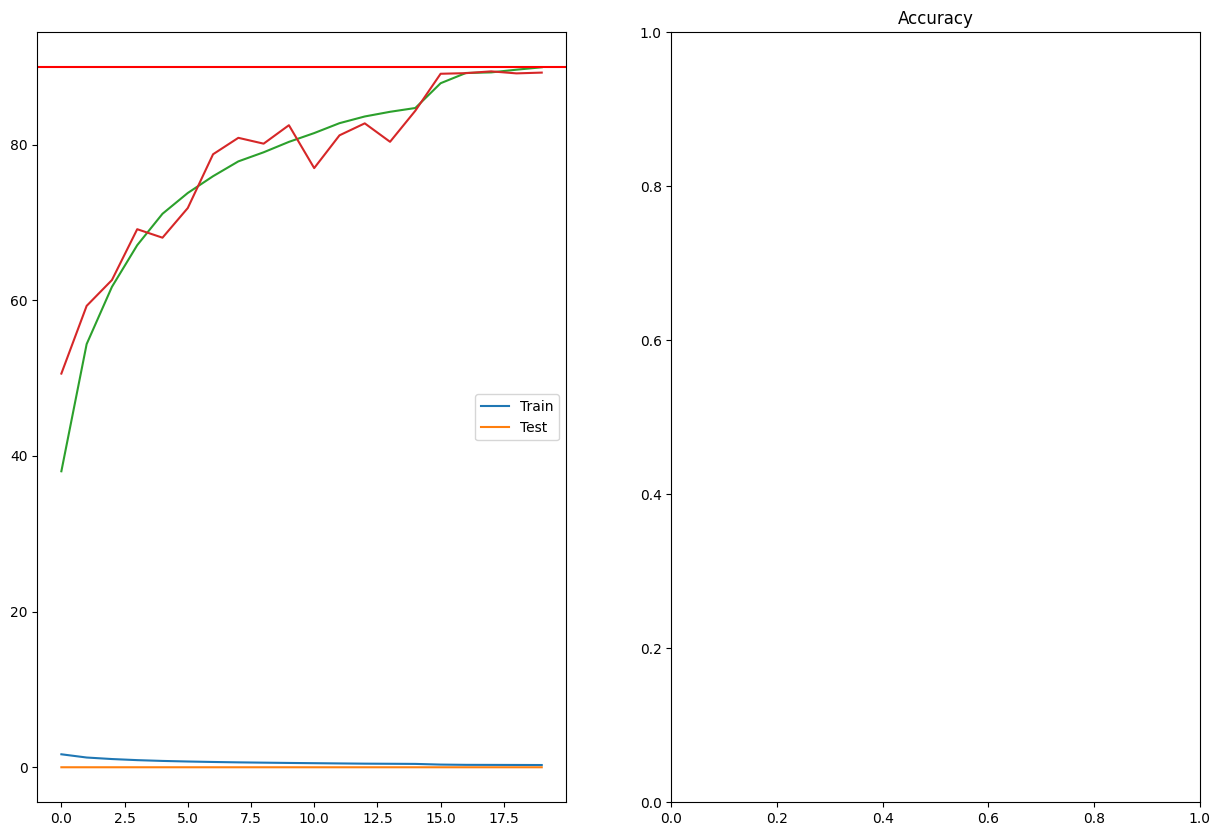

In [45]:
plot_lr_values(lr_values)
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc=90.)


Print Training Log

In [46]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.6696627602285268 |  0.002676322400569916 |     38.03      |    50.58     |
|   2   |  1.2541125599218874 |  0.002293989551067352 |     54.37      |    59.28     |
|   3   |  1.058799063064614  | 0.0022097944676876067 |     61.724     |     62.6     |
|   4   |  0.9177842809229481 | 0.0017800646483898163 |     67.078     |    69.13     |
|   5   |  0.8166992451463427 | 0.0019941176414489748 |     71.114     |    68.04     |
|   6   |  0.7420563071357961 | 0.0017103487253189087 |     73.784     |    71.85     |
|   7   |  0.6818826484436892 | 0.0012291806519031524 |     75.94      |    78.76     |
|   8   |  0.6322351164963781 | 0.0011138746738433838 |     77.844     |    80.87     |
|   9   |  0.5942750557952997 | 